In [222]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [223]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.python.framework.ops import disable_eager_execution
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob

In [224]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.Crust_Generator import CrustGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score
# from vis.visualization import visualize_saliency, visualize_cam, overlay

In [279]:
Data_set_name = 'San_Jacinto/'
mini_EXP_name = 'new_combined_exp/'
DATA_DIR = '../raw_data/'+ 'San_Jacinto/'+'crustal_new/'
MODEL_DIR = 'experiments/' + Data_set_name
exp_folder_path = MODEL_DIR + '/' + mini_EXP_name
EXPERIMENT= 'all'
#DATA_DIR1 = '../processed_input_data_' + EXPERIMENT + '/'

NPY_FOLDER = 'slice_npy/'
F_MASTER = 'file_master'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'

#crustal data location
RAW_DATA_FOLDER = 'raw_data/' + Data_set_name + 'crustal_new/'
RAW_MAT_FOLDER = RAW_DATA_FOLDER + 'raw_mat/'
RAW_NPY_FOLDER = RAW_DATA_FOLDER + 'raw_npy/'

json_path = os.path.join(exp_folder_path, 'params.json')
params = Params(json_path)

In [280]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**1+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),1*SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_avSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.08), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_mostSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.2), dtype = "float32"))
    return C_accuracy 

In [281]:
mini_e = mini_EXP_name
exp_folder_path = MODEL_DIR + '/' + mini_e
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-26-0.81.hdf5
weights-improvement-18-0.81.hdf5
weights-improvement-28-0.82.hdf5
weights-improvement-01-0.24.hdf5
weights-improvement-15-0.73.hdf5
weights-improvement-16-0.71.hdf5
weights-improvement-31-0.85.hdf5
weights-improvement-24-0.83.hdf5
weights-improvement-34-0.86.hdf5
weights-improvement-22-0.80.hdf5
weights-improvement-03-0.63.hdf5
weights-improvement-08-0.74.hdf5
weights-improvement-05-0.78.hdf5
weights-improvement-04-0.65.hdf5
weights-improvement-02-0.48.hdf5


In [282]:
selectedE = 34
selected_weights = ''
for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-34-0.86.hdf5


In [283]:
filepath = exp_folder_path + '/' + selected_weights 
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD,
                                "custom_accuracy_SD": custom_accuracy_SD,
                                "custom_accuracy_avSD": custom_accuracy_avSD})

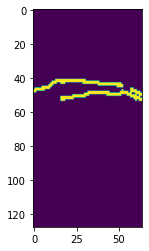

In [284]:
image = np.load('../'+ RAW_NPY_FOLDER + '0.00_0.00_'+'SJ1_1_00.npy')
image.reshape([*image.shape, 1])
plt.imshow(image)

In [285]:
crustal_generator  = CrustGenerator('crustal.txt',
                                    batch_size = 1, 
                                    group = 'raw_npy/', data_dir= '../'+ RAW_DATA_FOLDER)

sample#: 15
['0.00_0.00_SJ1_1_00.npy' '0.00_0.00_SJ1_1_01.npy'
 '0.00_0.00_SJ1_1_02.npy' '0.00_0.00_SJ1_1_03.npy'
 '0.00_0.00_SJ1_1_04.npy' '0.00_0.00_SJ1_1_05.npy'
 '0.00_0.00_SJ1_1_06.npy' '0.00_0.00_SJ1_1_07.npy'
 '0.00_0.00_SJ1_1_08.npy' '0.00_0.00_SJ1_1_09.npy'
 '0.00_0.00_SJ1_1_10.npy' '0.00_0.00_SJ1_1_11.npy'
 '0.00_0.00_SJ1_1_12.npy' '0.00_0.00_SJ1_1_13.npy'
 '0.00_0.00_SJ1_1_14.npy']


In [286]:
crust_pred = best_model.predict(crustal_generator)

In [287]:
print(len(crustal_generator))
print(len(crustal_generator[0]))
print(crustal_generator[0][0].shape)
print(crustal_generator[0][1].shape)

15
2
(1, 128, 64, 1)
(1, 2)


In [288]:
print(crust_pred)

[[0.5980374 ]
 [0.59108806]
 [0.67690396]
 [0.6612372 ]
 [0.6320669 ]
 [0.5428167 ]
 [0.5479546 ]
 [0.7638763 ]
 [0.775908  ]
 [0.62819886]
 [0.9415589 ]
 [1.191881  ]
 [1.2116748 ]
 [0.8131499 ]
 [0.54493535]]


In [289]:
list_exp = crustal_generator.filenames
print(list_exp)
for x in list_exp:
    print(x[10:18])

['0.00_0.00_SJ1_1_00.npy' '0.00_0.00_SJ1_1_01.npy'
 '0.00_0.00_SJ1_1_02.npy' '0.00_0.00_SJ1_1_03.npy'
 '0.00_0.00_SJ1_1_04.npy' '0.00_0.00_SJ1_1_05.npy'
 '0.00_0.00_SJ1_1_06.npy' '0.00_0.00_SJ1_1_07.npy'
 '0.00_0.00_SJ1_1_08.npy' '0.00_0.00_SJ1_1_09.npy'
 '0.00_0.00_SJ1_1_10.npy' '0.00_0.00_SJ1_1_11.npy'
 '0.00_0.00_SJ1_1_12.npy' '0.00_0.00_SJ1_1_13.npy'
 '0.00_0.00_SJ1_1_14.npy']
SJ1_1_00
SJ1_1_01
SJ1_1_02
SJ1_1_03
SJ1_1_04
SJ1_1_05
SJ1_1_06
SJ1_1_07
SJ1_1_08
SJ1_1_09
SJ1_1_10
SJ1_1_11
SJ1_1_12
SJ1_1_13
SJ1_1_14


In [290]:
print(crustal_generator.KEs)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


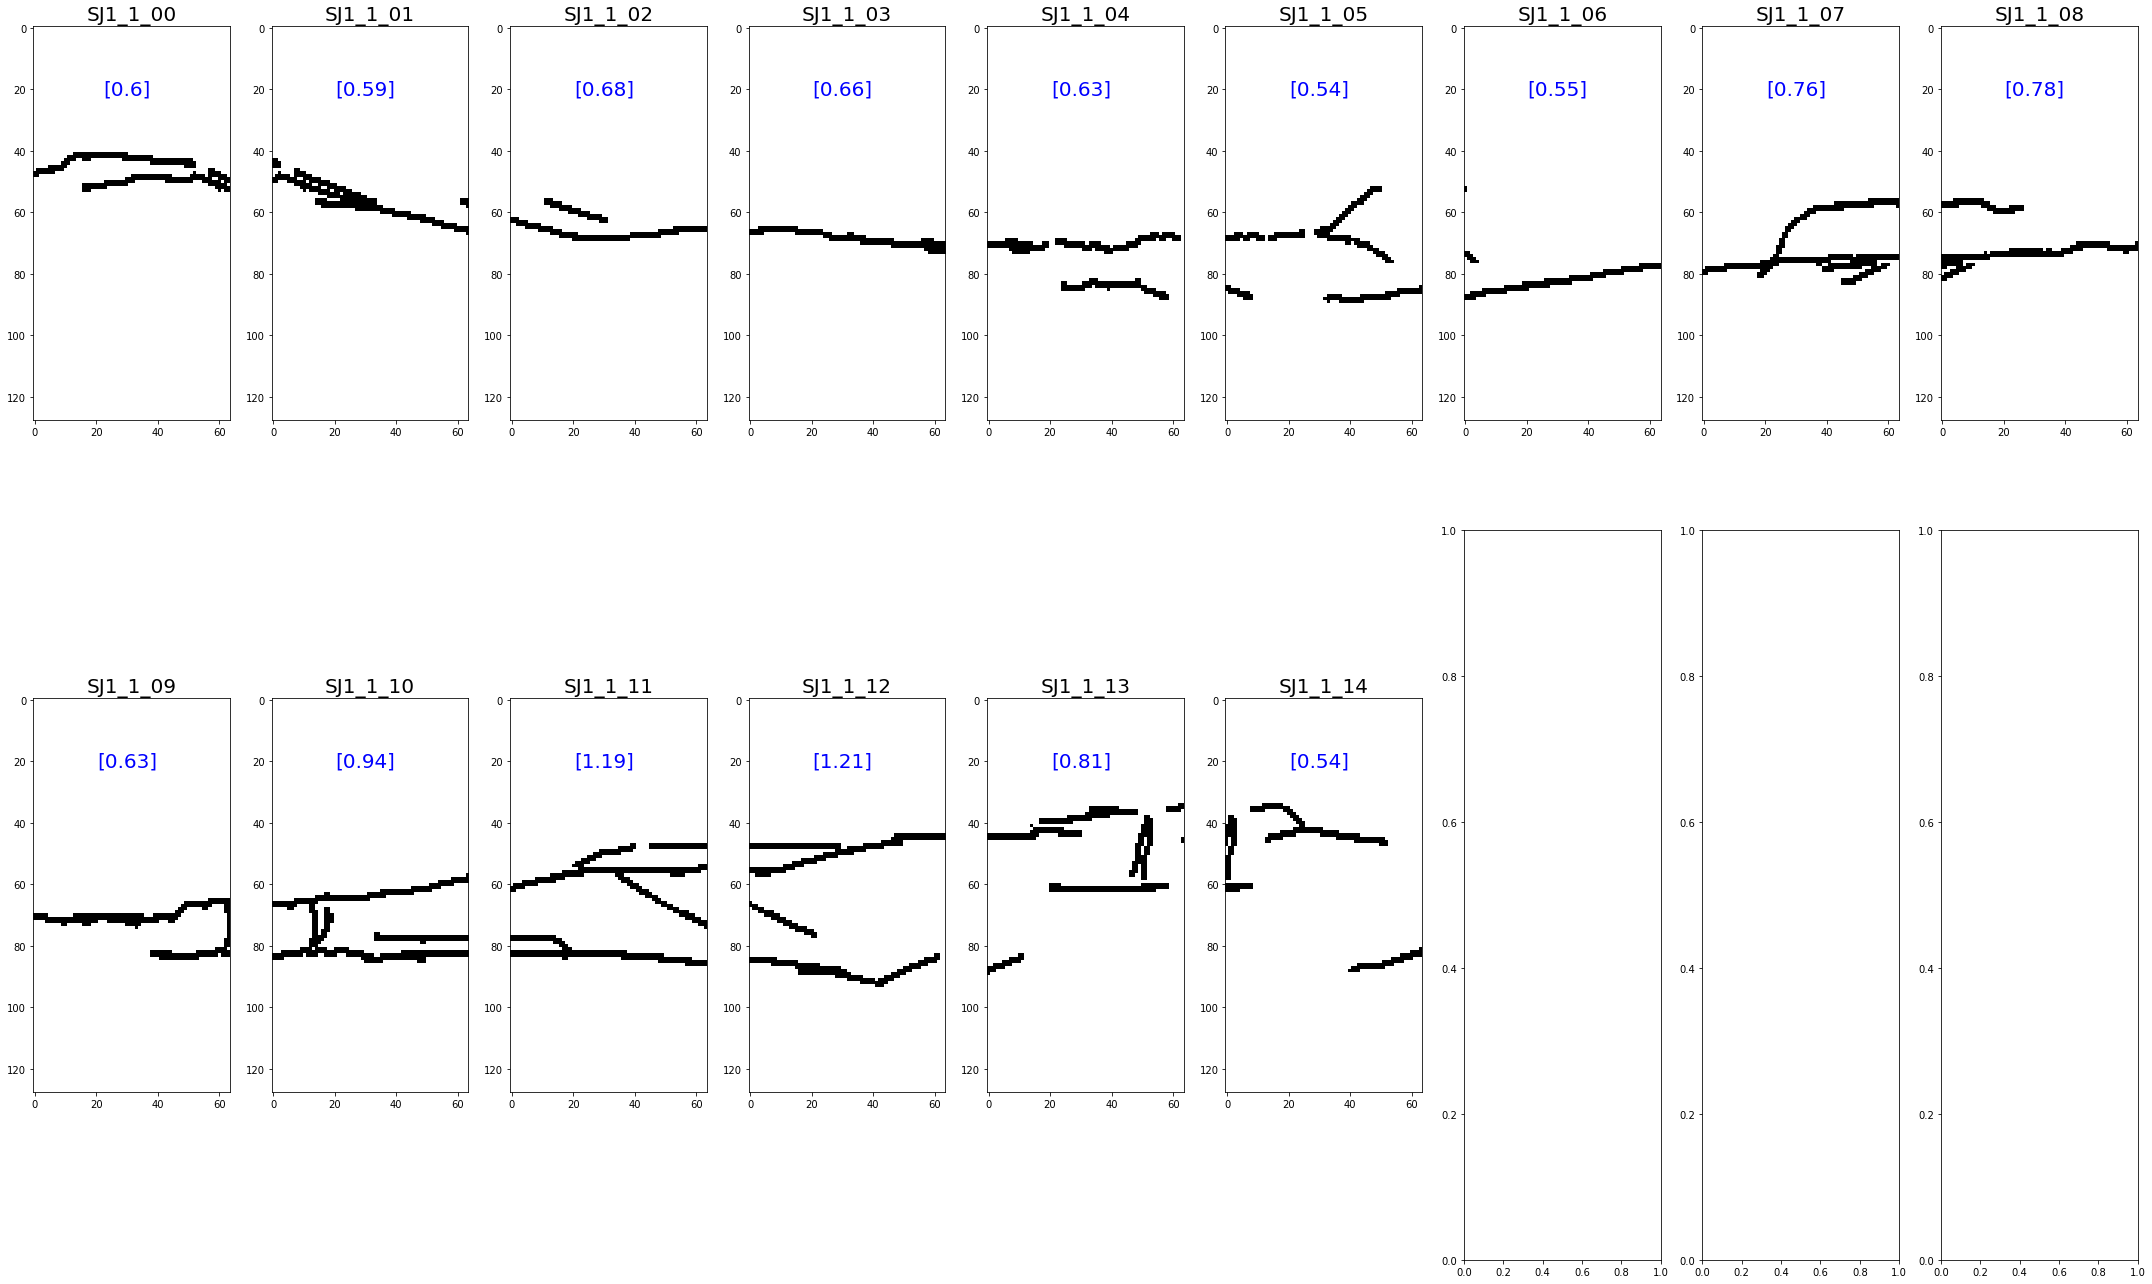

In [291]:
fig, axs = plt.subplots(2,9,figsize = (30,20))
ax_flat = axs.flatten()
for i, e in enumerate(list_exp):
    data = np.load('../'+ RAW_NPY_FOLDER + str(e))
    ax_flat[i].set_title(str(e[10:18]),fontsize=20)
    KE_pred = ax_flat[i].text(30,20, str(np.round(crust_pred[i],2)), fontsize =20,
                           ha="center", va="center", color="b")
    ax_flat[i].imshow(data, cmap='Greys')
plt.tight_layout()

In [103]:
crustal_generator  = CrustGenerator('crustal.txt',
                                    batch_size = 1, 
                                    group = 'crustal_npy/', data_dir=DATA_DIR)
crust_pred = best_model.predict(crustal_generator)
print(crust_pred)

sample#: 17
['0.00_0.00_MD1_1_00.npy' '0.00_0.00_MD1_1_01.npy'
 '0.00_0.00_MD1_1_02.npy' '0.00_0.00_MD1_1_03.npy'
 '0.00_0.00_MD1_1_04.npy' '0.00_0.00_MD1_1_05.npy'
 '0.00_0.00_MD1_1_06.npy' '0.00_0.00_MD1_1_07.npy'
 '0.00_0.00_MD1_1_08.npy' '0.00_0.00_MD1_1_09.npy'
 '0.00_0.00_MD1_1_10.npy' '0.00_0.00_MD1_1_11.npy'
 '0.00_0.00_MD1_1_12.npy' '0.00_0.00_MD1_1_13.npy'
 '0.00_0.00_MD1_1_14.npy' '0.00_0.00_MD1_1_15.npy'
 '0.00_0.00_MD1_1_16.npy']


FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/Maduo/crustal_new/crustal_npy/0.00_0.00_MD1_1_00.npy'

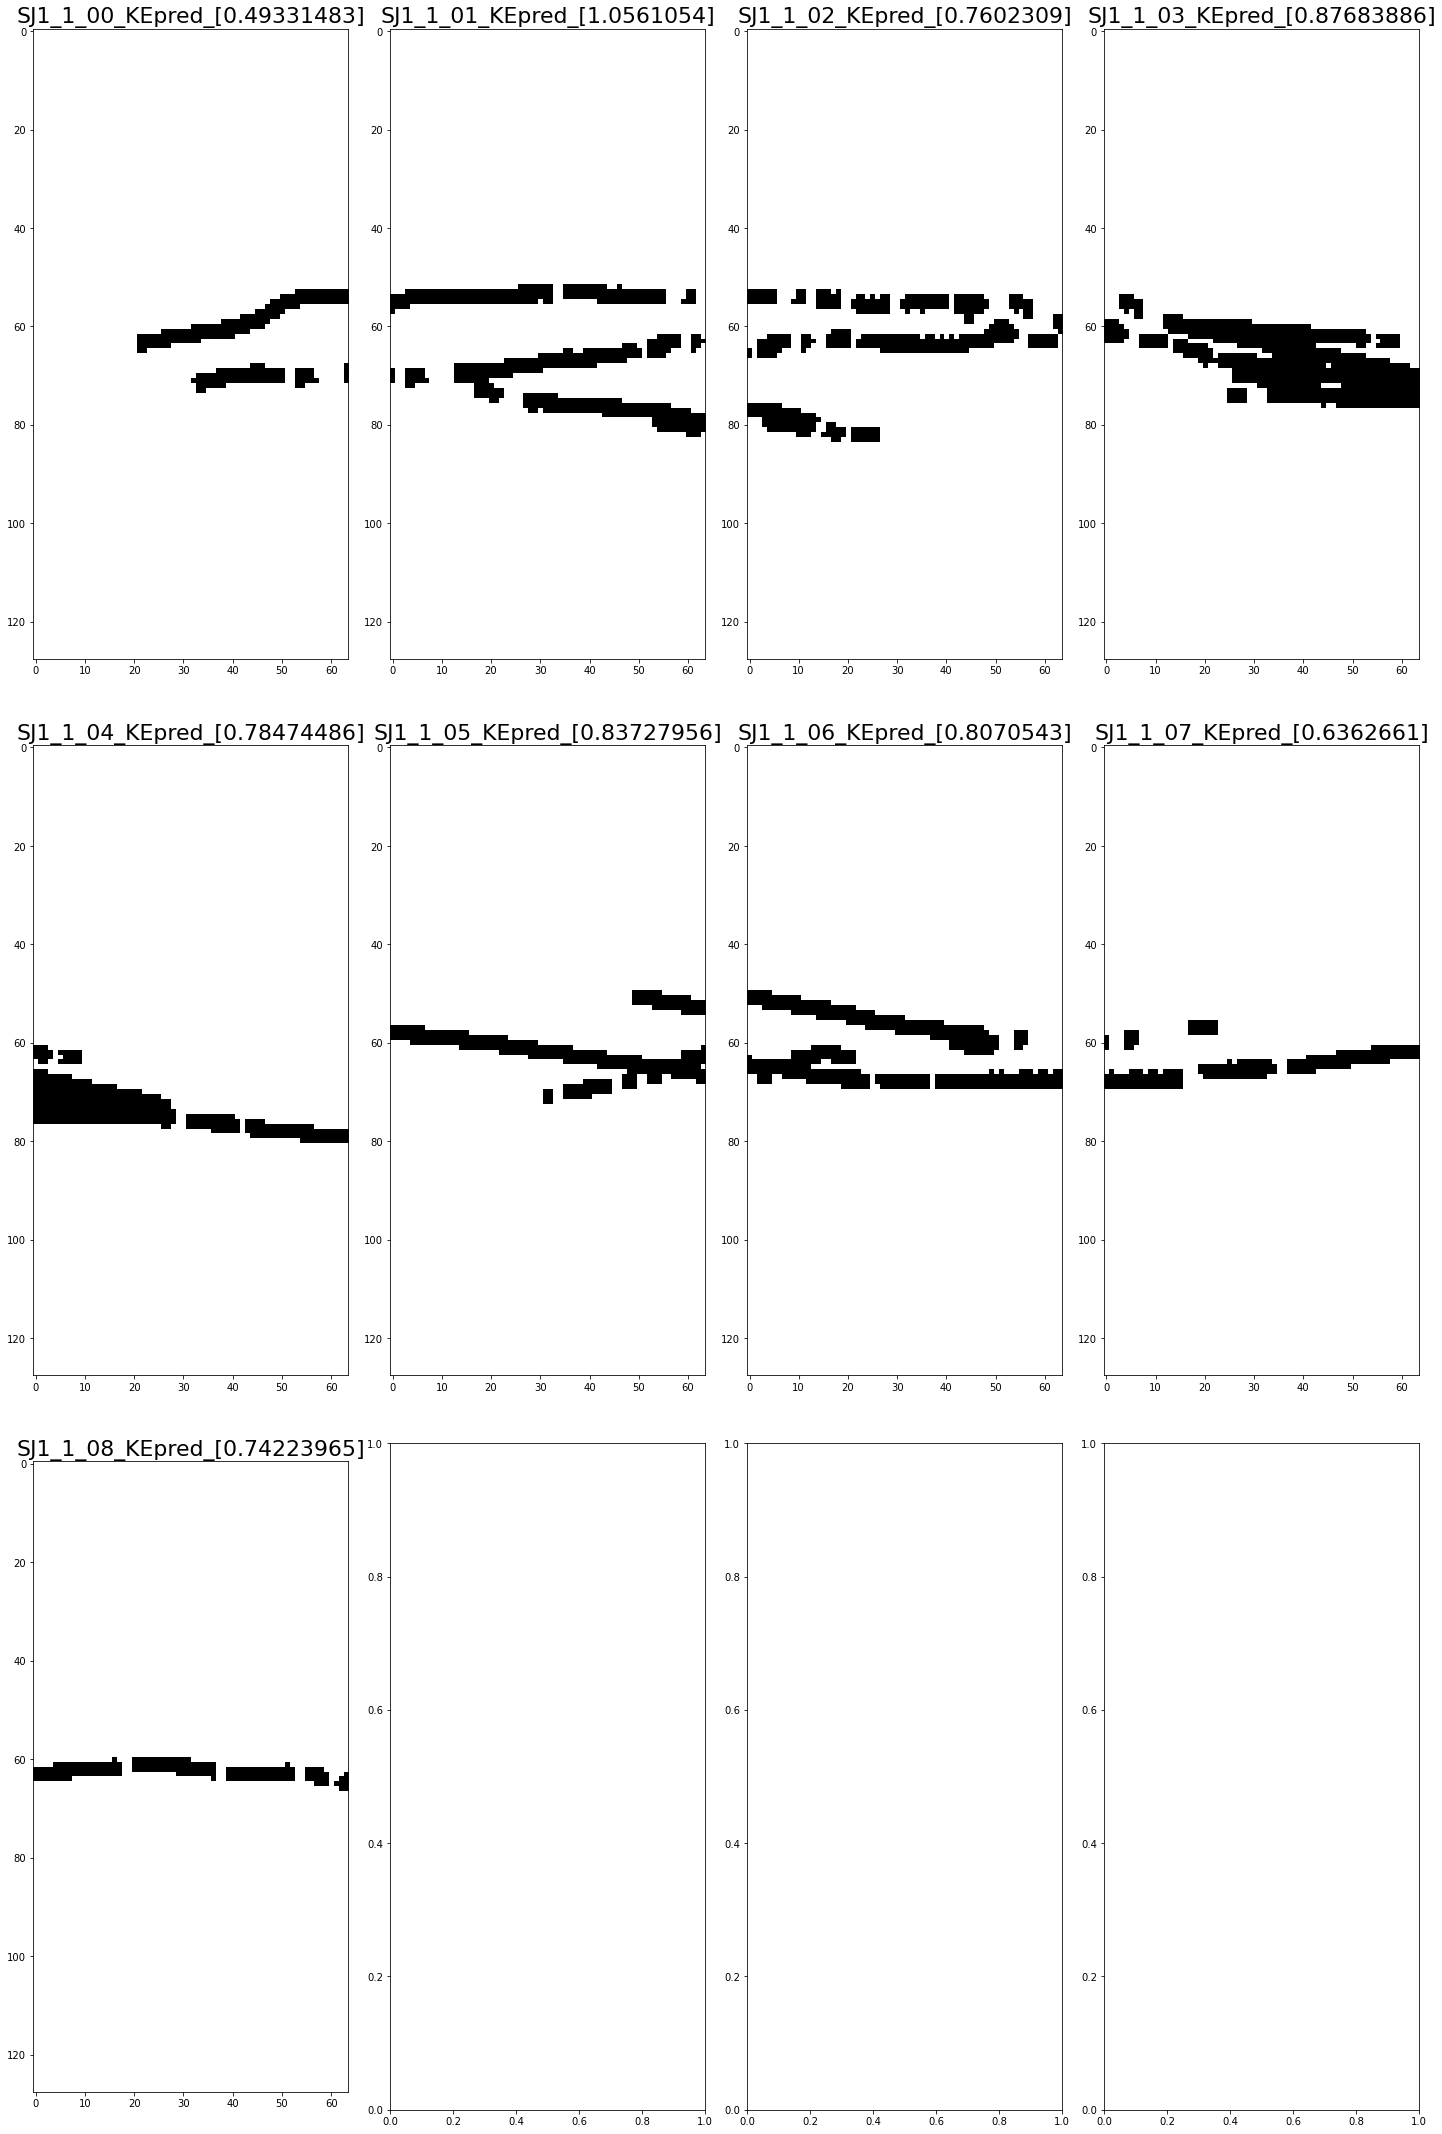

In [111]:
exp = ['SJ1_1_00', 'SJ1_1_01', 'SJ1_1_02', 'SJ1_1_03', 'SJ1_1_04', 'SJ1_1_05', 'SJ1_1_06', 'SJ1_1_07', 'SJ1_1_08' ]
fig, axs = plt.subplots(3, 4, figsize = (20,30))
for i, e in enumerate(exp):
    data = np.load(DATA_DIR+ 'crustal_npy/0.00_0.00_' + str(e) +'.npy')
    axs[i//4][i%4].set_title(str(e) + '_KEpred_' + str(crust_pred[i]),fontsize=22)
    axs[i//4][i%4].imshow(data, cmap='Greys')
plt.tight_layout()

In [69]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
    raw_history = yaml.load(filehandle2, Loader = yaml.Loader)

In [70]:
val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [71]:
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = 1, 
                                   data_dir=DATA_DIR1, shuffle = False)

1520
1520


In [72]:
test_pred = best_model.predict(test_generator)
print(len(test_pred))
print(test_pred)

1520
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [45]:
print(len(test_generator))
print(len(test_generator[0]))
print(test_generator[3000][0].shape)
print(test_generator[3000][1].shape)
print(test_generator[0][1])
test_size = (len(test_generator))
print(test_size)

1520
2
(1, 128, 64, 1)
(0, 2)
[[0.     0.0182]]
1520


In [46]:
import random
from random import randrange
test_size = (len(test_generator))
print(test_size)
test_random = [randrange(test_size) for i in range(12)]
print(test_random)


1520
[554, 1411, 726, 1380, 731, 414, 461, 1369, 1283, 743, 1146, 1039]


database =  EB_050_2/0.6634_0.1046_win_2_t_198_EB_050_2_cfuv.npy
KE_label = [0.6634 0.1046]
True
database =  PP_100_2/0.9378_0.0613_win_3_t_101_PP_100_2_cfuv.npy
KE_label = [0.9378 0.0613]
True
database =  EB_050_3/0.7640_0.0767_win_1_t_184_EB_050_3_cfuv.npy
KE_label = [0.764  0.0767]
True
database =  PP_100_2/0.6703_0.0799_win_3_t_070_PP_100_2_cfuv.npy
KE_label = [0.6703 0.0799]
True
database =  EB_050_3/0.7573_0.0802_win_1_t_189_EB_050_3_cfuv.npy
KE_label = [0.7573 0.0802]
True
database =  EB_050_2/0.0000_0.0326_win_2_t_057_EB_050_2_cfuv.npy
KE_label = [0.     0.0326]
True
database =  EB_050_2/0.5267_0.1174_win_2_t_105_EB_050_2_cfuv.npy
KE_label = [0.5267 0.1174]
True
database =  PP_100_2/0.1821_0.0801_win_3_t_059_PP_100_2_cfuv.npy
KE_label = [0.1821 0.0801]
True
database =  PP_050_2/0.8572_0.1002_win_1_t_138_PP_050_2_cfuv.npy
KE_label = [0.8572 0.1002]
True
database =  EB_050_3/0.7674_0.0954_win_1_t_201_EB_050_3_cfuv.npy
KE_label = [0.7674 0.0954]
True
database =  PP_025_2/0.9364_0.

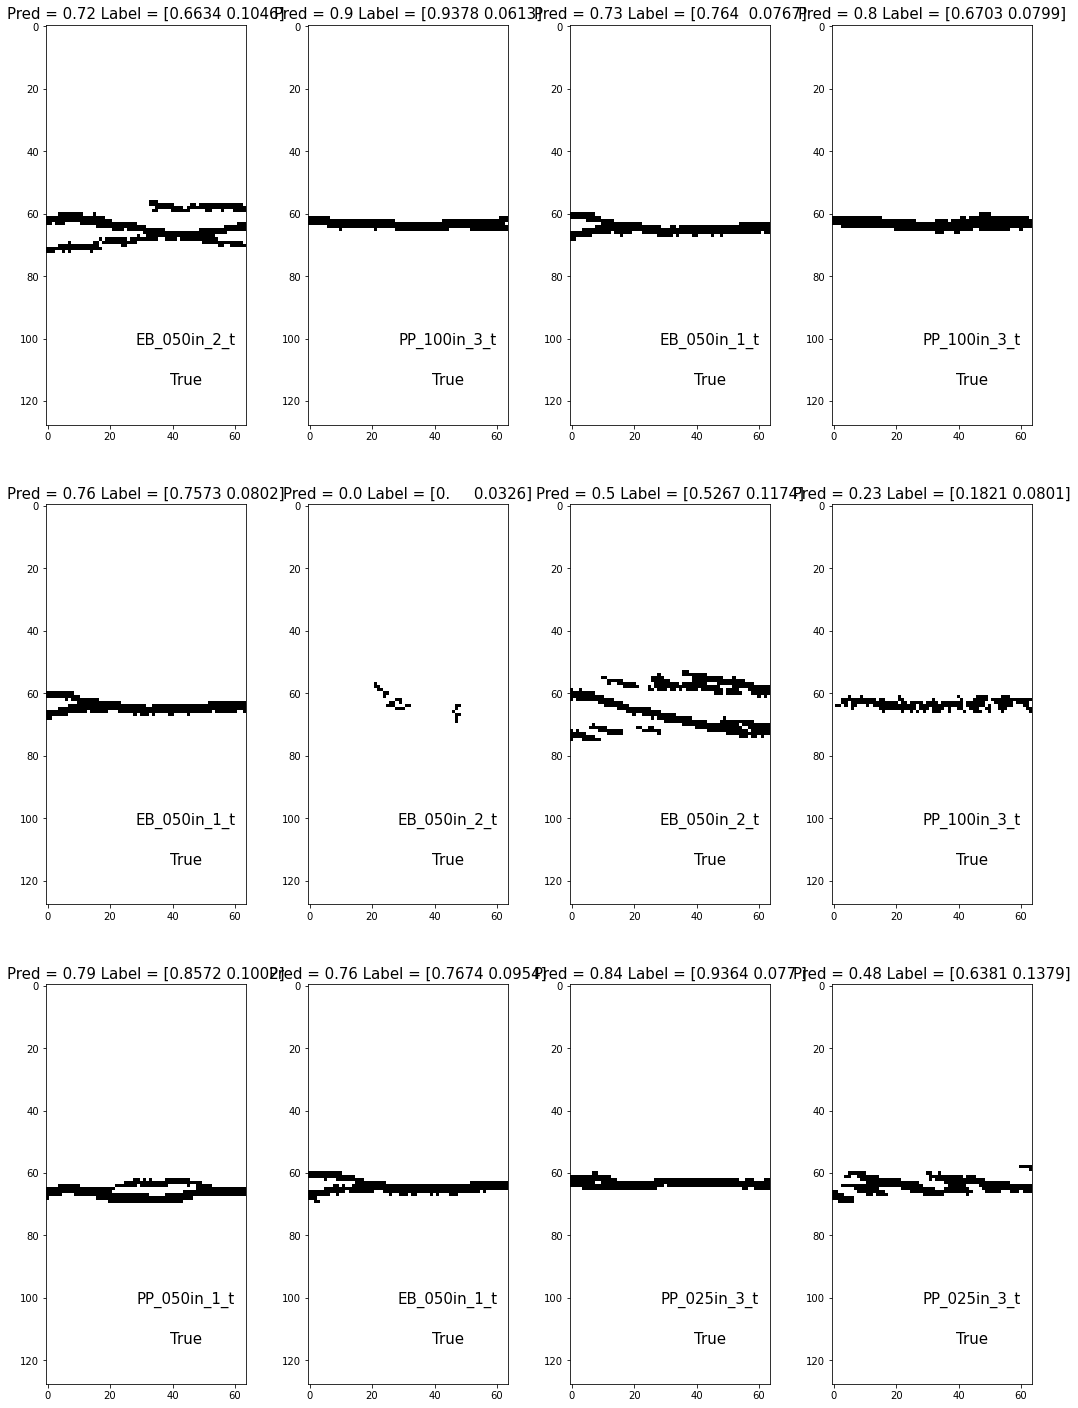

In [47]:
fig, axs = plt.subplots(3, 4, figsize = (18,25))
for i, e in enumerate (test_random):
    #test generator provide image of (1,128,64,1) dimension
    # use np.squeeze to reduce dimension to (128,64)
    image = np.squeeze(test_generator[e][0])
    label = test_generator[e][1]
    filename = test_generator.filenames[e]
    print('database = ', filename)
    pred = np.round(test_pred[e],2)
    print ('KE_label =', label[0])
    axs[i//4][i%4].set_title('Pred = ' + str(pred[0]) +' Label = '+ str(label[0]),fontsize=15)
    axs[i//4][i%4].imshow(image, cmap='Greys')
    if np.abs(pred[0]-label[0][0]) <= 2*label[0][1]:
        text = 'True'
        print(text)
    else:
        text = 'False'
        print(text)
    axs[i//4][i%4].text(0.7, 0.1, text, 
                 horizontalalignment = 'center', transform=axs[i//4][i%4].transAxes, fontsize=15)
    axs[i//4][i%4].text(0.7, 0.2, filename[0:6]+filename[24:30], 
                        horizontalalignment = 'center', transform=axs[i//4][i%4].transAxes, fontsize=15)
# axs[i].title.set_text(str(e) + '_pred_' + str(crust_pred[i]))

In [48]:
def Figure1(mini_exp, final_EPOCH):
    exp_folder_path = MODEL_DIR + '/' + mini_exp
    with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
        raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
    val_loss = raw_history['val_loss']
    train_accuracy = raw_history['custom_accuracy_2SD']
    val_accuracy = raw_history['val_custom_accuracy_2SD']
    best_model_EPOCH = val_loss.index(min(val_loss)) + 1 

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,2), facecolor='lightgrey')
    fig.suptitle('EXP:' + str(mini_exp), fontsize=16)
    
    axs[0].plot(raw_history['loss'][0:final_EPOCH])
    axs[0].plot(raw_history['val_loss'][0:final_EPOCH])
    axs[0].set_ylim([0, 100])
    axs[0].set_xlim([0, final_EPOCH])
    axs[0].set_xlabel('Epoch', fontsize = 20)
    axs[0].set_ylabel('Loss', fontsize = 20)
    axs[0].legend(['Train','Eval'], loc='upper right')

    axs[1].plot(raw_history['custom_accuracy_2SD'][0:final_EPOCH])
    axs[1].plot(raw_history['val_custom_accuracy_2SD'][0:final_EPOCH])
    axs[1].set_ylim([0, 1])
    axs[1].set_xlim([0, final_EPOCH])
    axs[1].set_xlabel('Epoch', fontsize = 20)
    axs[1].set_ylabel('2SD_Accuracy', fontsize = 20)
    axs[1].legend(['Train','Eval'], loc='upper right')
    
    axs[2].plot(raw_history['mse'][0:final_EPOCH])
    axs[2].plot(raw_history['val_mse'][0:final_EPOCH])
    axs[2].set_ylim([0, 1])
    axs[2].set_xlim([0, final_EPOCH])
    axs[2].set_xlabel('Epoch', fontsize = 20)
    axs[2].set_ylabel('MSE', fontsize = 20)
    axs[2].legend(['Train','Eval'], loc='upper right')

In [49]:
mini_exp = glob.glob(MODEL_DIR + '/*',  
                   recursive = True) 
mini_exp_list = []
for file in mini_exp: 
    mini_exp_list.append(file.split('/')[-1]) 

for f in mini_exp_list:
    print (f)

new_clay_exp


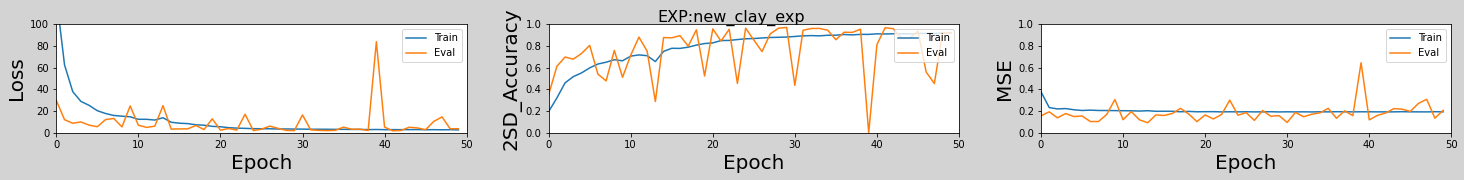

In [50]:
for minie in mini_exp_list:
    Figure1(minie, 50)

In [51]:
def Figure2(mini_exp_list, final_EPOCH):        
    for mini_e in mini_exp_list:
        exp_folder_path = MODEL_DIR + '/' + mini_e
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_loss = raw_history['loss']
        val_loss = raw_history['val_loss']
        train_accuracy = raw_history['custom_accuracy_2SD']
        val_accuracy = raw_history['val_custom_accuracy_2SD']
        best_model_EPOCH = val_loss.index(min(val_loss)) + 1
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
        #     print (file)
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list 
        
             
        Loss_list = list(val_loss[i] for i in b_ep_list)
        plt.plot(b_ep_list,Loss_list, marker='o', linestyle='dashed')
        plt.rcParams["figure.figsize"] = (15,10)
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.xlim([0,final_EPOCH])
        plt.ylim([1,6])
        plt.legend(mini_exp_list, loc='upper right')
#         plt.legend(['Train','Eval'], loc='upper left')

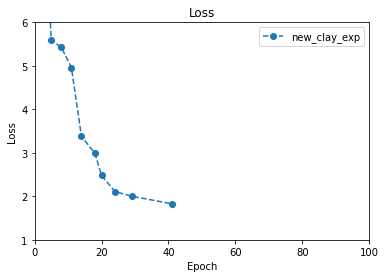

In [52]:
Figure2(mini_exp_list, 100)

In [53]:
def Figure3(mini_exp_list, final_EPOCH):        
    for mini_e in mini_exp_list:
        exp_folder_path = MODEL_DIR + '/' + mini_e
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_loss = raw_history['loss']
        val_loss = raw_history['val_loss']
        train_accuracy = raw_history['custom_accuracy_2SD']
        val_accuracy = raw_history['val_custom_accuracy_2SD']
        best_model_EPOCH = val_loss.index(min(val_loss)) + 1
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
        #     print (file)
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list 
        
             
        AC_list = list(val_accuracy[i] for i in b_ep_list)
        plt.plot(b_ep_list,AC_list, marker='o', linestyle='dashed')
        plt.rcParams["figure.figsize"] = (10,10)
        plt.title('custom_accuracy_2SD')
        plt.ylabel('custom_accuracy_2SD')
        plt.xlabel('Epoch')
        plt.xlim([0,final_EPOCH])
        plt.ylim([0.7,0.95])
        plt.legend(mini_exp_list, loc='lower right')
#         plt.legend(['Train','Eval'], loc='upper left')

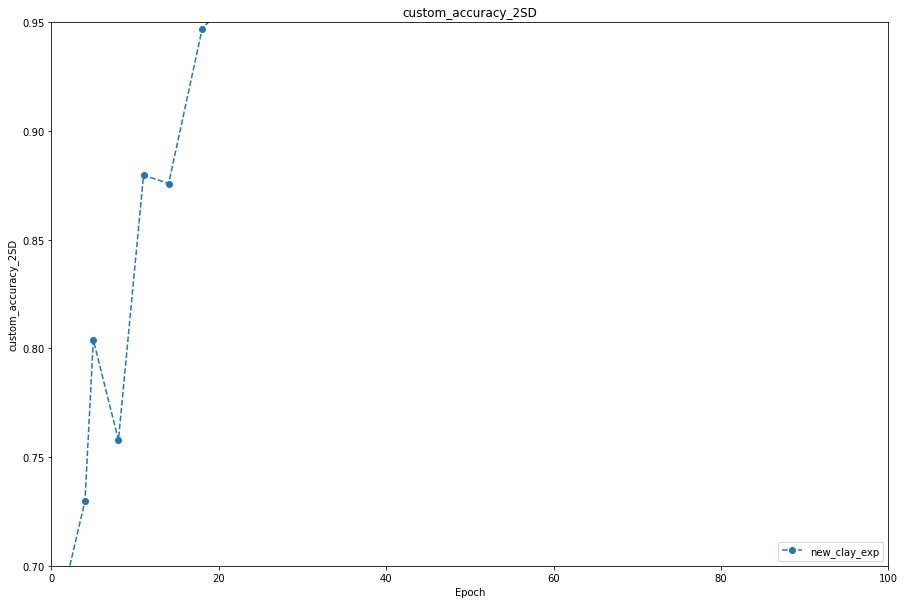

In [54]:
Figure3(mini_exp_list, 100)

In [55]:
mini_e = 'new_clay_exp'
exp_folder_path = MODEL_DIR + '/' + mini_e
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-01-0.35.hdf5
weights-improvement-02-0.61.hdf5
weights-improvement-03-0.70.hdf5
weights-improvement-05-0.73.hdf5
weights-improvement-06-0.80.hdf5
weights-improvement-09-0.76.hdf5
weights-improvement-12-0.88.hdf5
weights-improvement-15-0.88.hdf5
weights-improvement-19-0.95.hdf5
weights-improvement-21-0.96.hdf5
weights-improvement-25-0.96.hdf5
weights-improvement-30-0.97.hdf5
weights-improvement-42-0.97.hdf5


In [56]:
selectedE = 42
for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        print (file)

weights-improvement-42-0.97.hdf5


In [58]:
selected_weights = "/weights-improvement-42-0.97.hdf5"
filepath = exp_folder_path + selected_weights 
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD,
                                "custom_accuracy_SD": custom_accuracy_SD,
                                "custom_accuracy_avSD": custom_accuracy_avSD})

In [60]:
json_path = os.path.join(exp_folder_path, 'params.json')
params = Params(json_path)

##
input_slice_shape = (128,64,1)
batch_size = params.batch_size
MMT = params.bn_momentum
LR = params.learning_rate
num_channels = params.num_channels
#EPOCH = params.num_epochs
EPOCH = 100

In [62]:
#apply best model to three subset of data

##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR1, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR1, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR1, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

9480
9480
1521
1521
1520
1520


In [63]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [64]:
def plotting_with_TS(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig = plt.figure(figsize=(25,6))
    fig.suptitle("EXP: " + str(EXP) + " | Epoch: " + str(selected_EP),  fontsize=18)
    
    for g, m, num in zip(generator_LSP, mode, range(1,4)): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        
        ax = fig.add_subplot(1,3,num)
        ax.plot(pred, label,'o')
        ax.plot(pred[idx], label[idx], 'ro')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m) + ':' + '% error larger than 2SD = ' +str(error_pct) + '%')
        ax.text(0.7, 0.1, mini_EXP_name, 
                 horizontalalignment = 'center', transform=plt.gca().transAxes)
        ax.set_xlabel(str(m) + '_prediction')
        ax.set_ylabel(str(m) + '_truth')    
    plt.show
#     plt.savefig(exp_folder_path +'/' + str(mode) + '_prediction2SD.png')

9472
1280
1280


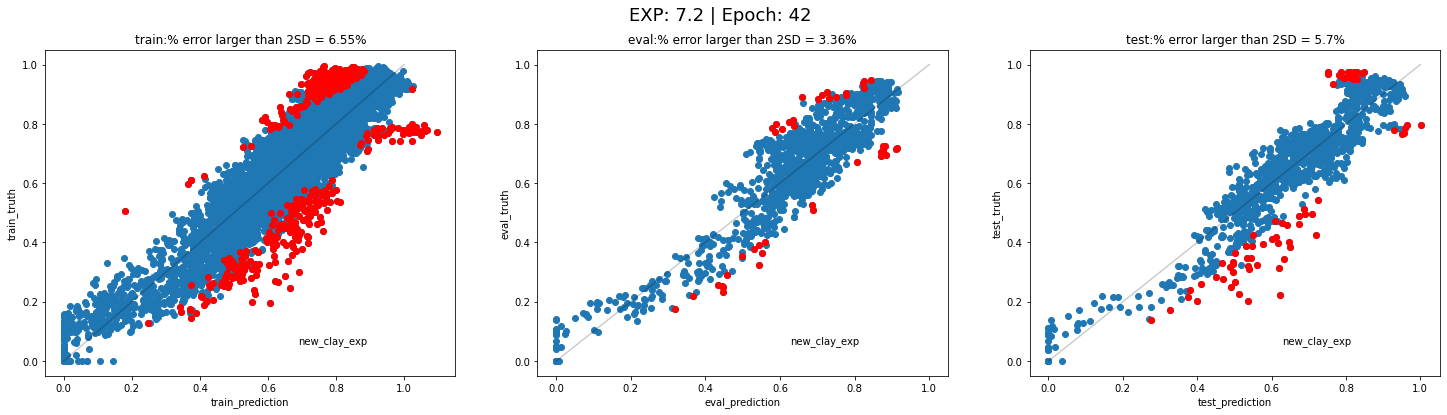

In [65]:
plotting_with_TS(generator_LSP, ['train', 'eval', 'test'], EXP = 7.2, selected_EP = selectedE)